In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
import json as jsn
import geopandas as gpd
import shapely as shply
import rle as rle
import os as os

from scipy.special import expit

from werp_projecting_sfis.get_rating_tables_and_cross_sections import * 

In [2]:
parentdire = '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/'
filelist = os.listdir('//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/')
filelist = [file for file in filelist if '.nc' in file]
filelist = [parentdire + file for file in filelist if '_P0' in file]
filelist

['//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0M000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0W000_flow.nc']

In [3]:
scenarios = [file.split('0')[1] for file in filelist]
scenarios

['D', 'H', 'M', 'W']

In [4]:
mdbboundary = gpd.read_file("Z:/Data/GIS/General/mdb_boundary.shp")

In [5]:
filelist

['//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0M000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0W000_flow.nc']

In [6]:
infiles = xr.open_mfdataset(filelist, combine = 'nested', concat_dim= 'scenario')



In [7]:
infiles = infiles.assign_coords({'scenario' :scenarios})

In [8]:
infile_histemp = xr.open_dataset(r"\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\test_silo_sfi_drill_max_temp.nc")

In [9]:
infile_hist = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc")
infile_fut = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc") 



In [10]:
infile_hist

<xarray.Dataset> Size: 72MB
Dimensions:         (station: 214, time: 41638)
Coordinates:
  * station         (station) int32 856B 1 2 3 4 5 6 ... 209 210 211 212 213 214
  * time            (time) datetime64[ns] 333kB 1895-07-01 ... 2009-06-30
Data variables:
    station_me      (station) <U48 41kB ...
    station_no      (station) <U8 7kB ...
    station_id      (station) int32 856B ...
    Site            (station) <U7 6kB ...
    spatial_coords  (station) <U94 80kB ...
    lon             (station) float64 2kB ...
    lat             (station) float64 2kB ...
    flow            (station, time) float64 71MB ...
Attributes:
    title:           A continuous daily time series of data generated from IR...
    institution:     MDBA
    source:          IRSMF Outlook23 model results
    catchment:       Murray-Darling Basin
    history:         This data has been generated by the IRSMF for the Outloo...
    comment:         CSIRO has migrated these datasets to netcdf for the purp...
    MDBA_attrs:      Capture required attributes for MDBA data registry systems
    crs:             4283
    data variables:  Flow

In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

file_path = r"\\fs1-cbr.nexus.csiro.au\{ev-mdb-outlook}\work\fre171\results_to_nc\flow_columns_clean.csv"
site_mapper = pd.read_csv(file_path)
 
site_mapper.columns

Index(['station_me', 'station_longme', 'station_no', 'station_id',
       'station_latitude', 'station_longitude', 'station_carteasting',
       'station_cartnorthing', 'station_georefsystem', 'site_no', 'site_id',
       'DATA_OWNER', 'DATA_OWNER_ME', 'Field', 'Site', 'Measurand', 'Quality',
       'me.x', 'Description.x', 'file', 'SITEID', 'index', 'me.y',
       'Description.y', 'x_sec', 'rating', 'gaugings', 'flood_level',
       'VisCode', 'Unnamed: 29'],
      dtype='object')

In [12]:

 
 
# Create a GeoDataFrame
# Define a function to clean strings
def clean_string(s):
    return s.strip().replace('"', "").replace("'", "") if isinstance(s, str) else s
 
 
# Read the CSV file with string cleaning
file_path = r"\\fs1-cbr.nexus.csiro.au\{ev-mdb-outlook}\work\fre171\results_to_nc\flow_columns_clean.csv"
df = pd.read_csv(
    file_path,
    # converters={
    #     col: clean_string for col in df.select_dtypes(include=["object"]).columns
    # },
)
 
# Create a geometry column from latitude and longitude
geometry = [Point(xy) for xy in zip(df["station_longitude"], df["station_latitude"])]
 
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)
 
# Set the coordinate reference system (CRS) to WGS84
gdf.set_crs(epsg=4326, inplace=True)
 
# Drop any columns you don't want in the final GeoJSON
# In this case, we're keeping all columns, but you can modify this list if needed
columns_to_drop = []
gdf = gdf.drop(columns=columns_to_drop)
 
# Save to GeoJSON
gdf.to_file(r"\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\allsites.geojson", driver="GeoJSON")
 
print("GeoJSON file created successfully.")

GeoJSON file created successfully.


In [13]:
sites_to_use1 = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))

In [14]:
sites_to_use1

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  28,
         29,  30,  35,  36,  37,  38,  39,  42,  43,  44,  45,  46,  47,
         48,  50,  52,  54,  55,  56,  57,  58,  59,  60,  61,  65,  66,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 136, 137, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170,
        171, 172, 173, 176, 185, 186, 187, 190, 194, 195, 196, 197, 199,
        200, 201, 202, 204, 205, 207, 209, 210, 211, 212, 213], dtype=int64),)

In [15]:
sites_to_use = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))

In [16]:
stationid = infile_hist['station_no'][sites_to_use].values[20]
stationid

'416028'

<Axes: >

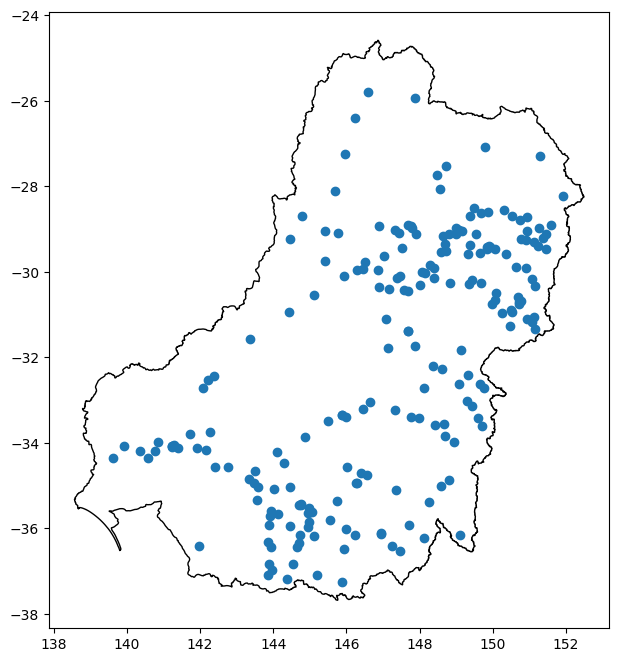

In [17]:

fig, axs = plt.subplots(1,1,figsize=(8,8) )
df = pd.DataFrame({'lat': infile_hist['lat'] ,'lon': infile_hist['lon'],'id': infile_hist['station_no']})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326" )

gdf.plot(ax = axs)
mdbboundary.plot(color='None', ax = axs)

<Axes: >

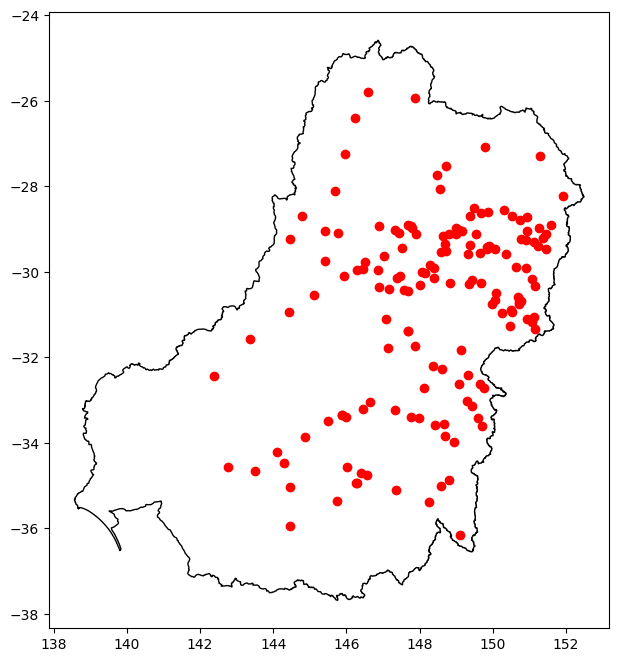

In [18]:
fig, axs = plt.subplots(1,1,figsize=(8,8) )
df = pd.DataFrame({'lat': infile_hist['lat'][sites_to_use] ,'lon': infile_hist['lon'][sites_to_use],'id': infile_hist['station_no'][sites_to_use]})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326" )

gdf.plot(ax = axs, c="red")
mdbboundary.plot(color='None', ax = axs)

In [19]:
i = sites_to_use[0][4]
print(i)

ii = np.where(infile_histemp['station_no'] == infile_hist['station_no'][i].values)[0]
print(ii)

5
[5]


In [20]:
i = sites_to_use[0][4]
print(i)

ii = np.where(infile_histemp['station_no'] == infile_hist['station_no'][i].values)[0]

starttime = max(infile_hist['time'].min(), infile_histemp['time'].min()).values
endtime = min(infile_hist['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)


indata = infile_hist['flow'][i].sel(time = slice(starttime, endtime)).squeeze()
infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime)).squeeze()
intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime)).squeeze()

probs = [0.1,0.05,0.02,0.01,0.005]
quants = indata.quantile(q =probs)
print(quants.values)

tempthresholds = [-100,35,40,45]
nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
nyears

5
1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
[152.76472778 107.53434181  70.60105057  54.99146206  43.37036148]


114

c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


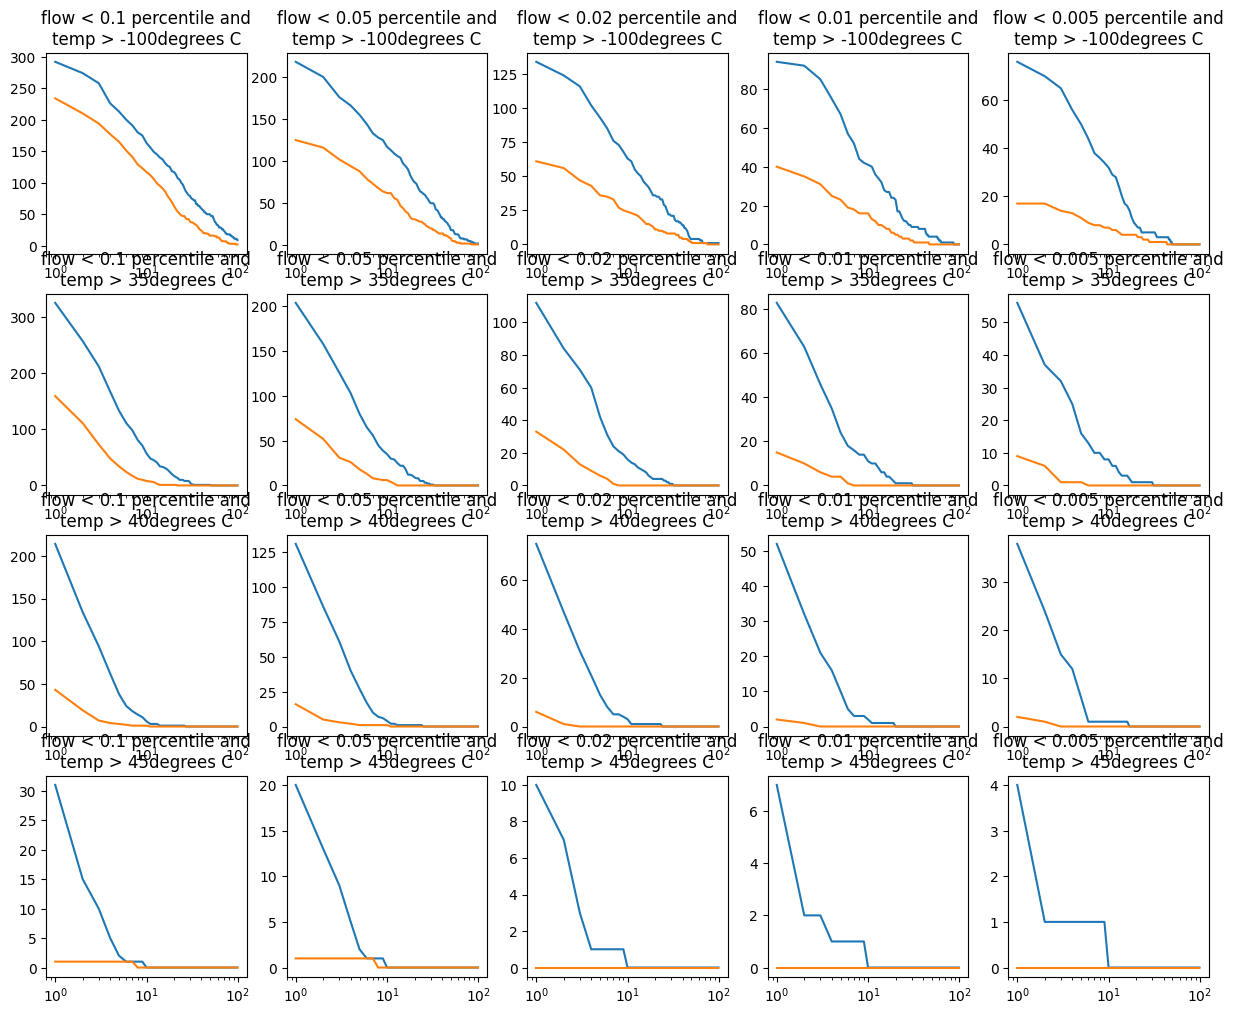

In [21]:
thresholdi = 0
thresholdj = 2
nx = len(quants.values)
ny =  len(tempthresholds)
figsize = 3

fig, ax = plt.subplots(ny,nx, figsize=(nx*figsize,ny*figsize))

outsummary = pd.DataFrame()

for thresholdi in range(len(quants.values)):
    for thresholdj in range(len(tempthresholds)):
        testdata = indata.values< quants.values[thresholdi]
        test2data = intemp.values > tempthresholds[thresholdj]
        finaldata = testdata & test2data
       # print(finaldata)
        encoding = rle.encode(finaldata)
        trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])

        testdatafut = infut.values<quants.values[thresholdi]
        test2datafut = intemp.values > (tempthresholds[thresholdj]-3.4)
        encodingfut = rle.encode(testdatafut & test2datafut)
        truesfut = np.array([ encodingfut[1][a] for a in range(len(encodingfut[0])) if encodingfut[0][a]])

        histbins = [a for a in range(1,100,1)]

        futtrues = [sum(truesfut>a) for a in histbins]
        histtrues = [sum(trues>a) for a in histbins]

        ax[thresholdj,thresholdi].plot(histbins, futtrues)
        ax[thresholdj,thresholdi].plot(histbins, histtrues)
        ax[thresholdj,thresholdi].set_xscale('log')
        ax[thresholdj,thresholdi].set_title( 'flow < ' + str(probs[thresholdi]) + ' percentile and\ntemp > ' + str(tempthresholds[thresholdj]) + 'degrees C' )

        pdout = pd.DataFrame({'temp_treshold': [ tempthresholds[thresholdj]], 'flow_percentile': [probs[thresholdi]], 'flow_treshold' : [quants.values[thresholdi]],
                             'mean_event_length_hist': [np.mean(trues)],'mean_event_length_future': [ np.mean(truesfut)], 
                             'event_frequency_hist': [(trues.shape[0]/nyears)], 'event_frequency_future':[truesfut.shape[0]/nyears]})
       # print(pdout)
        outsummary = pd.concat([outsummary, pdout])
#print(sum(trues), sum(truesfut))


In [22]:
outsummary

,temp_treshold,flow_percentile,flow_treshold,mean_event_length_hist,mean_event_length_future,event_frequency_hist,event_frequency_future
0,-100,0.100,152.764728,16.656000,24.374194,2.192982,2.719298
0,35,0.100,152.764728,3.396313,5.642857,1.903509,3.684211
0,40,0.100,152.764728,2.000000,2.966049,0.719298,2.842105
0,45,0.100,152.764728,3.333333,1.858974,0.026316,0.684211
0,-100,0.050,107.534342,15.422222,18.648536,1.184211,2.096491
0,35,0.050,107.534342,3.421569,5.370229,0.894737,2.298246
0,40,0.050,107.534342,1.864865,3.066327,0.324561,1.719298
0,45,0.050,107.534342,4.500000,2.019231,0.017544,0.456140
0,-100,0.020,70.601051,12.815385,15.719424,0.570175,1.219298
0,35,0.020,70.601051,2.913043,4.729560,0.403509,1.394737


In [23]:
np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))[0].shape

(154,)

In [24]:

sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))
i = sites_to_use[0][4]
print(i)

starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)


indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
#infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime))

indata = indata.drop_vars('station')
intemp = intemp.drop_vars('station')

probs = [0.99,0.90,0.05,0.01]
indata = indata.chunk(dict(scenario=-1, time = -1))
quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
print(quants)

tempthresholds = [-100,35,40,45]
nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

scenariotemps = np.array([3.0,0.0,2.9,2.1])


5
1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
[7.49523034e+04 1.07630308e+04 1.07534342e+02 5.49914621e+01]
114


In [25]:
indata.shape

(4, 41638)

In [26]:
def encodingfunc(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>=a) for a in bins])
    return(futtrues)

def xrencoding(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc, obj, input_core_dims = [[dim]], output_core_dims=[['counts']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_], kwargs={'bins':bins})

def encodingfunc1(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>=a) for a in bins])
    return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])

def xrencoding1(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc1, obj, input_core_dims = [[dim]], output_core_dims=[['counts'], ['means'],['lengths']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_,np.float_, np.int_], kwargs={'bins':bins})


In [27]:
thresholdi = 0
thresholdj = 2
nx = len(quants)
ny =  len(tempthresholds)
figsize = 3
nbins = 10000
#fig, ax = plt.subplots(ny,nx, figsize=(nx*figsize,ny*figsize))
bins = np.array([a for a in range(1,nbins,1)])
outsummary = pd.DataFrame()

testdata = indata<quants[thresholdi]
test2data = intemp > tempthresholds[thresholdj]
combined = (testdata & test2data)
combined = combined.compute()
result = xrencoding(combined,'time', bins=bins)
result = result.assign_coords({'counts':bins})

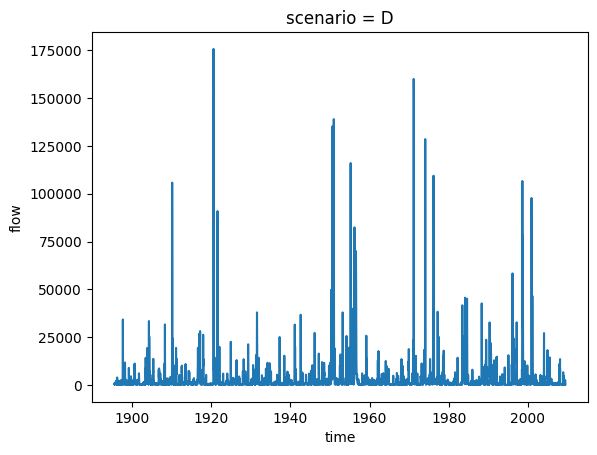

In [28]:
indata.loc[{'scenario':'D'}].plot()

In [29]:
encoding = rle.encode((indata.loc[{'scenario':'D'}]<=quants[0]).values)

In [30]:
trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
futtrues = np.array([sum(trues>a) for a in bins])

In [31]:
futtrues

array([14, 14, 14, ...,  1,  1,  1])

In [32]:
colors = {'H':'tab:green', 'W':'tab:blue', 'D':'tab:red', 'M':'tab:orange'}

In [33]:
temp_adjustments = scenariotemps[:,np.newaxis]
print(thresholdj)
intemp.values >= (tempthresholds[thresholdj] - temp_adjustments)

2


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [34]:
temp_adjustments

array([[3. ],
       [0. ],
       [2.9],
       [2.1]])

In [35]:
from dask import delayed, compute

In [36]:
testdata

<xarray.DataArray 'flow' (scenario: 4, time: 41638)> Size: 167kB
dask.array<lt, shape=(4, 41638), dtype=bool, chunksize=(4, 41638), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 333kB 1895-07-01 1895-07-02 ... 2009-06-30
  * scenario  (scenario) <U1 16B 'D' 'H' 'M' 'W'

In [37]:
result

<xarray.DataArray (scenario: 4, station: 1, counts: 9999)> Size: 160kB
array([[[554, 295, 147, ...,   0,   0,   0]],

       [[554, 295, 147, ...,   0,   0,   0]],

       [[554, 295, 147, ...,   0,   0,   0]],

       [[552, 293, 146, ...,   0,   0,   0]]])
Coordinates:
  * scenario  (scenario) <U1 16B 'D' 'H' 'M' 'W'
  * counts    (counts) int32 40kB 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Dimensions without coordinates: station

In [38]:
result.sel({'counts':5}).values/nyears

array([[0.42105263],
       [0.42105263],
       [0.42105263],
       [0.42105263]])

In [39]:
nx = len(quants)
ny =  len(tempthresholds)
figsize = 5
nbins = 10000
bins = np.array([a for a in range(1,nbins,1)])
# fig, ax = plt.subplots(ny,nx, figsize=(nx*figsize,ny*figsize))
indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
indata = indata.drop_vars('station')
intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime)).squeeze()
indata = indata.chunk(dict(scenario=-1, time = -1))
quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
testingtemps = intemp.expand_dims(dim={'scenario':4})
testingtemps = testingtemps.assign_coords(coords={'scenario' : indata['scenario']})
testingtemps = testingtemps + temp_adjustments

res_list = []

for thresholdi in range(len(quants)):
    for thresholdj in range(len(tempthresholds)):
        testdata = indata<=quants[thresholdi]
        test2data = testingtemps>=tempthresholds[thresholdj]
       # test2data = test2data.assign_coords(coords={'scenario' : indata['scenario']})

        combined = (testdata & test2data).compute()
        #combined = combined.compute()
        result, means, counts = xrencoding1(combined,'time', bins=bins)
        result = result.assign_coords({'counts':bins})
        # result.plot.line(hue = 'scenario', ax =  ax[thresholdj,thresholdi])

        # ax[thresholdj,thresholdi].set_xscale('log')
        # if(thresholdj==(len(tempthresholds)-1)):
        #     ax[thresholdj, thresholdi].set_xlabel('Event length')
        # else:
        #     ax[thresholdj, thresholdi].set_xlabel('')
        # if(thresholdi==0):    
        #     ax[thresholdj, thresholdi].set_ylabel('Number of events exceeding')
        # else:
        #     ax[thresholdj, thresholdi].set_ylabel('')
        # ax[thresholdj,thresholdi].set_title( 'flow < ' + str(probs[thresholdi]) + ' percentile and\ntemp > ' + str(tempthresholds[thresholdj]) + 'degrees C' )
        if (probs[thresholdi] > 0.5):
            pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0]/365.25,  'event_frequency': result.sel({'counts':1*365}).values,  '5day_event_frequency': result.sel({'counts':5*365}).values, '10day_event_frequency': result.sel({'counts':10*365}).values})
        else:
            pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':5}).values/nyears, '10day_event_frequency': result.sel({'counts':10}).values/nyears})

        #pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':5}).values/nyears})
        pdout['temp_treshold'] =  tempthresholds[thresholdj]
        pdout['flow_percentile'] =  probs[thresholdi]
        pdout['flow_treshold'] =  quants[thresholdi]
        # print(pdout)
        res_list.append(pdout)        
outsummary = pd.concat(res_list)
#print(sum(trues), sum(truesfut))


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [40]:
outsummary 

,scenarios,mean_event_length,event_frequency,5day_event_frequency,10day_event_frequency,temp_treshold,flow_percentile,flow_treshold
0,D,8.104429,10.000000,6.000000,5.0,-100,0.99,74952.303359
1,H,5.374140,12.000000,7.000000,5.0,-100,0.99,74952.303359
2,M,6.655232,11.000000,6.000000,5.0,-100,0.99,74952.303359
3,W,3.613875,19.000000,9.000000,4.0,-100,0.99,74952.303359
0,D,0.016377,0.000000,0.000000,0.0,35,0.99,74952.303359
...,...,...,...,...,...,...,...,...
3,W,1.500000,0.052632,0.000000,0.0,40,0.01,54.991462
0,D,2.071429,0.122807,0.008772,0.0,45,0.01,54.991462
1,H,NaN,0.000000,0.000000,0.0,45,0.01,54.991462
2,M,1.400000,0.043860,0.000000,0.0,45,0.01,54.991462


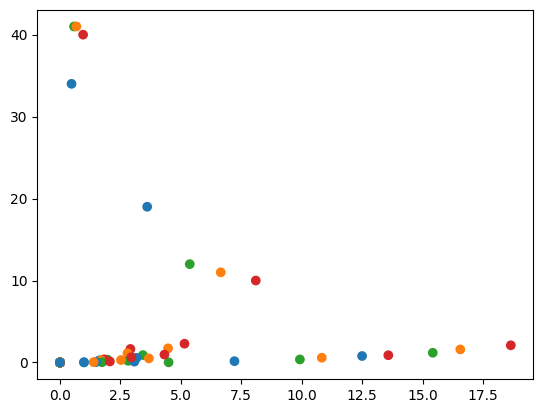

In [41]:
colors = {'H':'tab:green', 'W':'tab:blue', 'D':'tab:red', 'M':'tab:orange'}
plt.scatter(x = outsummary['mean_event_length'], y = outsummary['event_frequency'], c=outsummary['scenarios'].map(colors))

In [42]:
outsummary['5day_event_frequency']

0    6.000000
1    7.000000
2    6.000000
3    9.000000
0    0.000000
       ...   
3    0.000000
0    0.008772
1    0.000000
2    0.000000
3    0.000000
Name: 5day_event_frequency, Length: 64, dtype: float64

In [43]:
sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))[0]
len(sites_to_use)

154

In [44]:
sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))[0]

outsummary = pd.DataFrame()
starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)
probs = [0.99,0.95,0.1,0.05,0.01]
tempthresholds = [-100,35,40]
nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

scenariotemps = np.array([3.65,0.0,2.75,2.0])
results = []
for j in range(len(sites_to_use)):

    i = sites_to_use[j]
    ii = np.where(infile_histemp['station_no'] == infile_hist['station_no'][i].values)[0]

    print(i, ii)

    indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
    indata = indata.drop_vars('station')
    intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime)).squeeze()
    indata = indata.chunk(dict(scenario=-1, time = -1))
    quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
    testingtemps = intemp.expand_dims(dim={'scenario':4})
    testingtemps = testingtemps.assign_coords(coords={'scenario' : indata['scenario']})
    testingtemps = testingtemps + temp_adjustments

    for thresholdi in range(len(quants)):
        for thresholdj in range(len(tempthresholds)):
            testdata = indata<=quants[thresholdi]
            test2data = testingtemps>=tempthresholds[thresholdj]
            combined = (testdata & test2data).compute()
            result, means, counts = xrencoding1(combined,'time', bins=bins)
            result = result.assign_coords({'counts':bins})
            if (probs[thresholdi] > 0.5):
                pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0]/365.25,  'event_frequency': result.sel({'counts':1*365}).values,  '5day_event_frequency': result.sel({'counts':5*365}).values, '10day_event_frequency': result.sel({'counts':10*365}).values})
            else:
                pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':5}).values/nyears, '10day_event_frequency': result.sel({'counts':10}).values/nyears})
            pdout['temp_treshold'] =  tempthresholds[thresholdj]
            pdout['flow_percentile'] =  probs[thresholdi]
            pdout['flow_treshold'] =  quants[thresholdi]
            pdout['site'] =  infiles['station_no'].isel({'station':i}).values
            pdout['lat'] = infiles['lat'].isel({'station':i}).values
            pdout['lon'] = infiles['lon'].isel({'station':i}).values
            # print(pdout)
            results.append(pdout)

outsummary = pd.concat(results)
    #print(sum(trues), sum(truesfut))


1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
114
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10 [10]
11 [11]
12 [12]
13 [13]
14 [14]
15 [15]
16 [16]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

17 [17]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

18 [18]
19 [19]
20 [20]
21 [21]
22 [22]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 [25]
26 [26]
27 [27]
28 [28]
29 [29]
30 [30]
35 [35]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

36 [36]
37 [37]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


38 [38]
39 [39]
42 [42]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


43 [43]
44 [44]
45 [45]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


46 [46]
47 [47]
48 [48]
50 [50]
52 [52]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


54 [54]
55 [55]
56 [56]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


57 [57]
58 [58]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

59 [59]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

60 [60]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

61 [61]
65 [65]
66 [66]
72 [72]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


73 [73]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

74 [74]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

75 [75]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


76 [76]
77 [77]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

78 [78]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

79 [79]
80 [80]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

83 [83]
84 [84]
85 [85]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

86 [86]
87 [87]
88 [88]
89 [89]
90 [90]
91 [91]
92 [92]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


93 [93]
94 [94]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


101 [101]
102 [102]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

103 [103]
104 [104]
105 [105]
106 [106]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


107 [107]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


108 [108]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

109 [109]
110 [110]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


111 [111]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

112 [112]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


113 [113]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


114 [114]
115 [115]
116 [116]
117 [117]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


118 [118]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

119 [119]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


120 [120]
121 [121]
122 [122]
123 [123]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

124 [124]
125 [125]
126 [126]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

127 [127]
128 [128]
129 [129]
130 [130]
131 [131]
132 [132]
133 [133]
136 [136]
137 [137]
148 [148]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


149 [149]
150 [150]
151 [151]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


152 [152]
153 [153]
154 [154]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


155 [155]
156 [156]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


157 [157]
158 [158]
159 [159]
160 [160]
161 [161]
162 [162]
163 [163]
164 [164]
166 [166]
167 [167]
168 [168]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


169 [169]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

170 [170]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


171 [171]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

172 [172]
173 [173]
176 [176]
185 [185]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

186 [186]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

187 [187]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

190 [190]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

194 [194]
195 [195]
196 [196]
197 [197]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


199 [199]
200 [200]
201 [201]
202 [202]
204 [204]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


205 [205]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy

207 [207]
209 [209]
210 [210]
211 [211]
212 [212]
213 [213]


C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\663918595.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\Users\rob635\Documents\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3 [3]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4 [4]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5 [5]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6 [6]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

7 [7]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8 [8]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9 [9]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

10 [10]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

11 [11]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

12 [12]


C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_12380\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

13 [13]


KeyboardInterrupt: 

In [45]:
outsummary['flow_percentile'].unique()

array([0.99, 0.95, 0.1 , 0.05, 0.01])

In [46]:
outsummary.to_csv(os.path.join(r"\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater", "summary_results.csv"))

In [47]:
outsummary['flow_percentile'].unique()

array([0.99, 0.95, 0.1 , 0.05, 0.01])

In [48]:
outplot = outsummary[outsummary['flow_percentile']==0.1]
outplot = outplot[outplot['temp_treshold']==35]
outplot['scen_cat'] = outplot["scenarios"].astype('category')
outplot["scen_cat"] = outplot["scen_cat"].cat.reorder_categories(["H", "D", "M", "W"] )

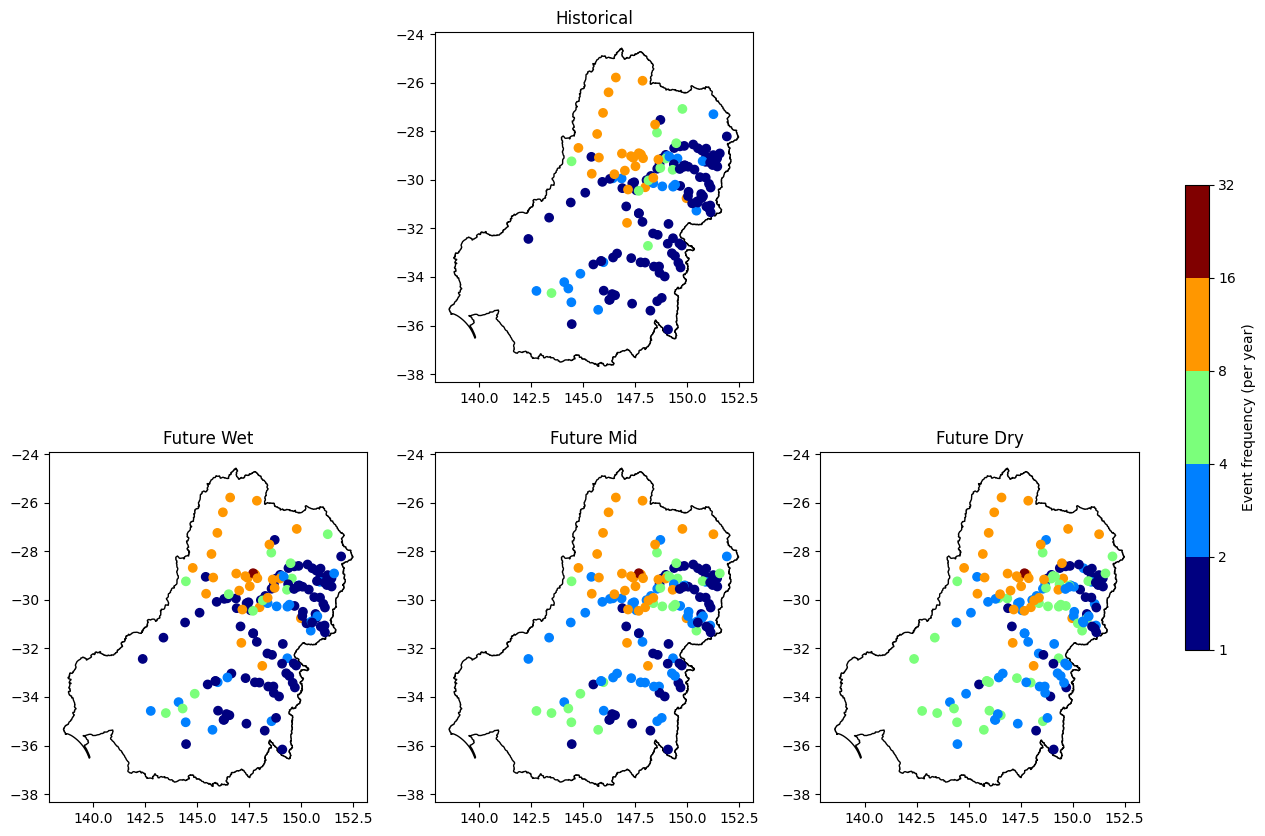

In [49]:
plot_variable_name = 'event_frequency'

maxscale = outplot[plot_variable_name].max()
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])


mdbboundary.plot(color = 'None', ax = axs[0,1])
spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")


fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Event frequency (per year)")



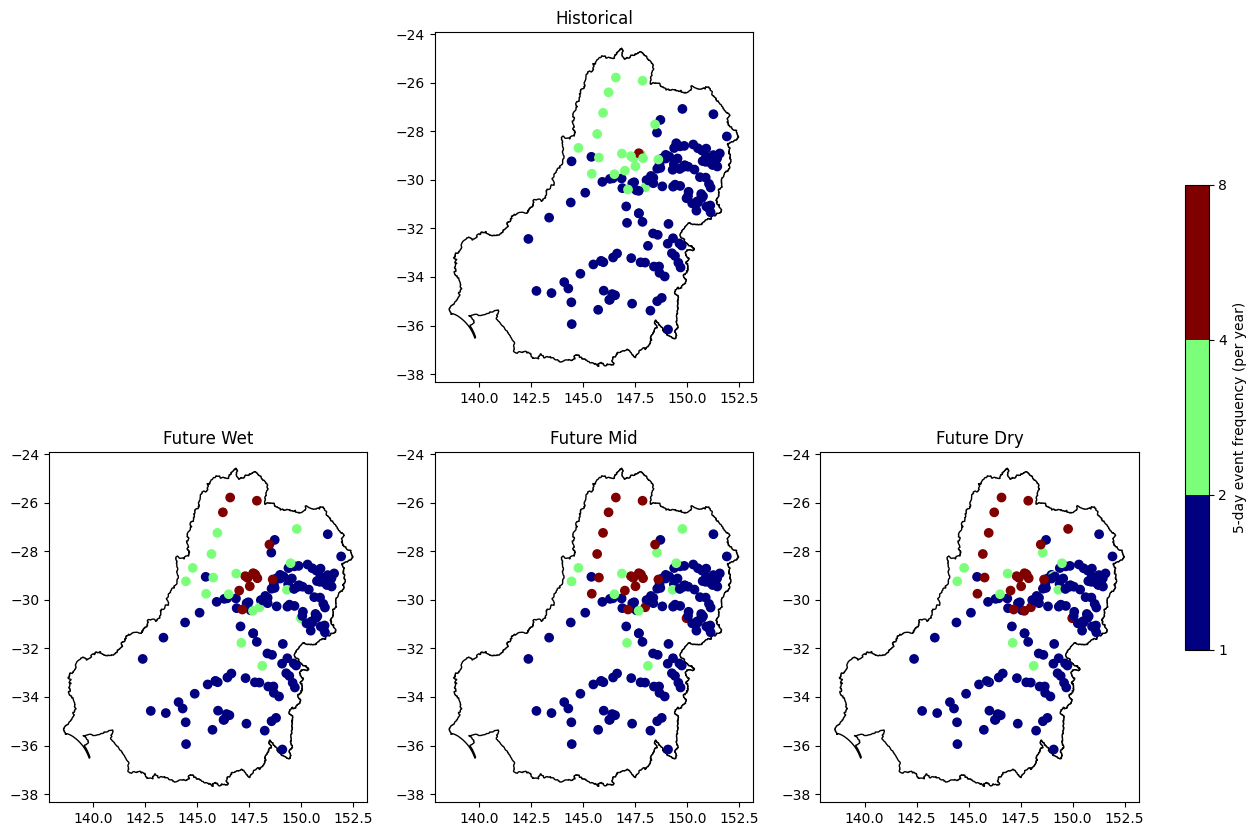

In [50]:
plot_variable_name = '5day_event_frequency'

maxscale = outplot[plot_variable_name].max()
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])


mdbboundary.plot(color = 'None', ax = axs[0,1])
spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")


fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "5-day event frequency (per year)")



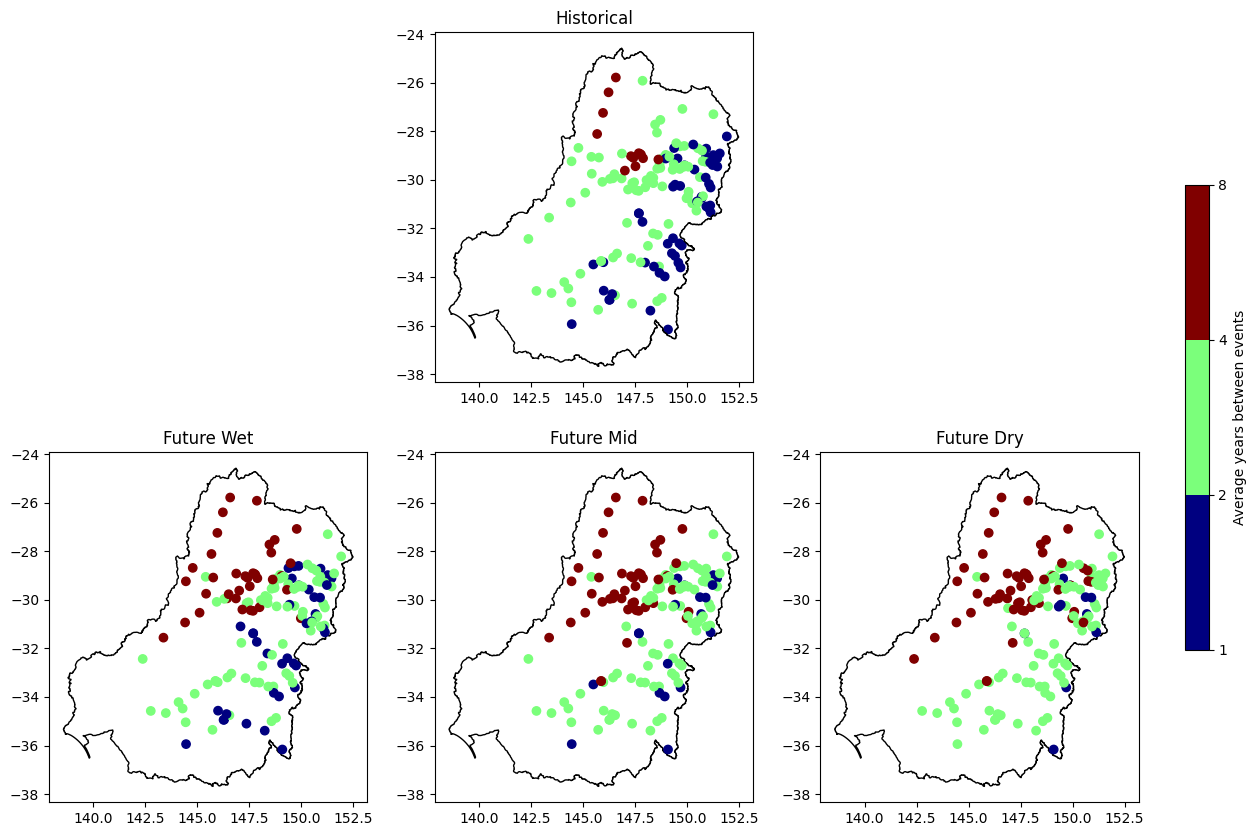

In [51]:
maxscale = outplot['mean_event_length'].max()

# define the bins and normalize
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1)) #np.logspace(np.log10(1), np.log10(nbounds),num=cmap.N)

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])

spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)

mdbboundary.plot(color = 'None', ax = axs[0,1])

axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")

fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Average years between events")




In [52]:
outplot2 = outplot.copy(deep=True)
unique_scenarios = outplot['scenarios'].unique()
for s in unique_scenarios:
    outplot2.loc[outplot2['scenarios']==s,'mean_event_length'] = outplot.loc[outplot['scenarios']==s,'mean_event_length'].values - outplot.loc[outplot['scenarios']=='H','mean_event_length'].values

In [53]:
bounds

array([1., 2., 4., 8.])

-1.0 2.746722200294264


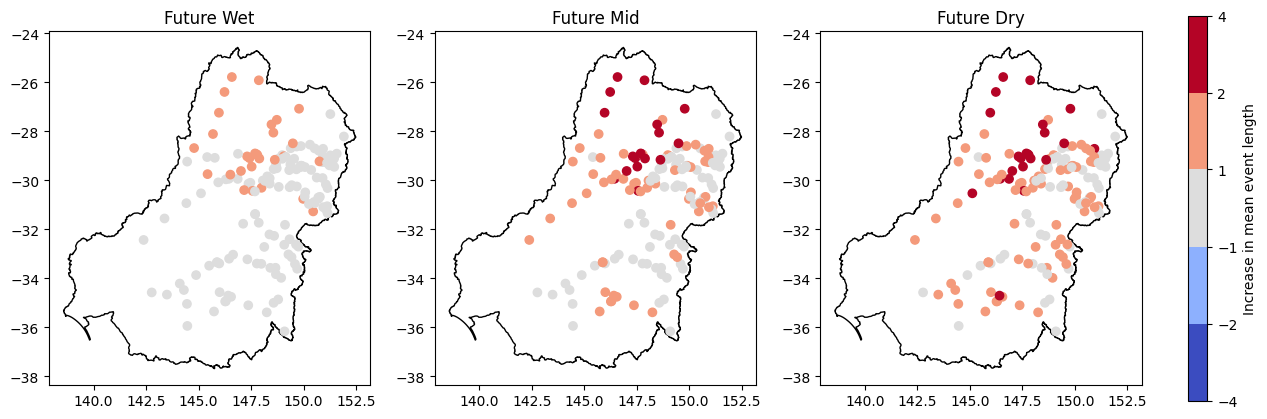

In [54]:
maxscale = outplot2['mean_event_length'].max()
minscale = outplot2['mean_event_length'].min()

print(minscale, maxscale)
cmap = plt.cm.coolwarm  # define the colormap


# define the bins and normalize
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1)) #np.logspace(np.log10(1), np.log10(nbounds),num=cmap.N)
bounds = np.concatenate((-1.0*bounds, bounds))
bounds = np.sort(bounds)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ncolors = len(bounds) - 1
cmaplist = [cmap(i) for i in range(ncolors)]

cmap = plt.get_cmap('coolwarm', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
#norm = plt.Normalize(0, maxscale)
fig, axs = plt.subplots(1,3,figsize=(15,5) )

mdbboundary.plot(color = 'None', ax = axs[0])
# (outplot2[outplot2['scenarios']=="W"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[0], legend = False)
spdata = outplot2[outplot2['scenarios']=="W"]
sc = axs[0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1])
# (outplot2[outplot2['scenarios']=="M"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[1], legend = False)
spdata = outplot2[outplot2['scenarios']=="M"]
sc = axs[1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[2])
spdata = outplot2[outplot2['scenarios']=="D"]
sc = axs[2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[2].set_title("Future Dry")



fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Increase in mean event length")

 

C:\Users\rob635\AppData\Local\Temp\2\ipykernel_5716\1733080234.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


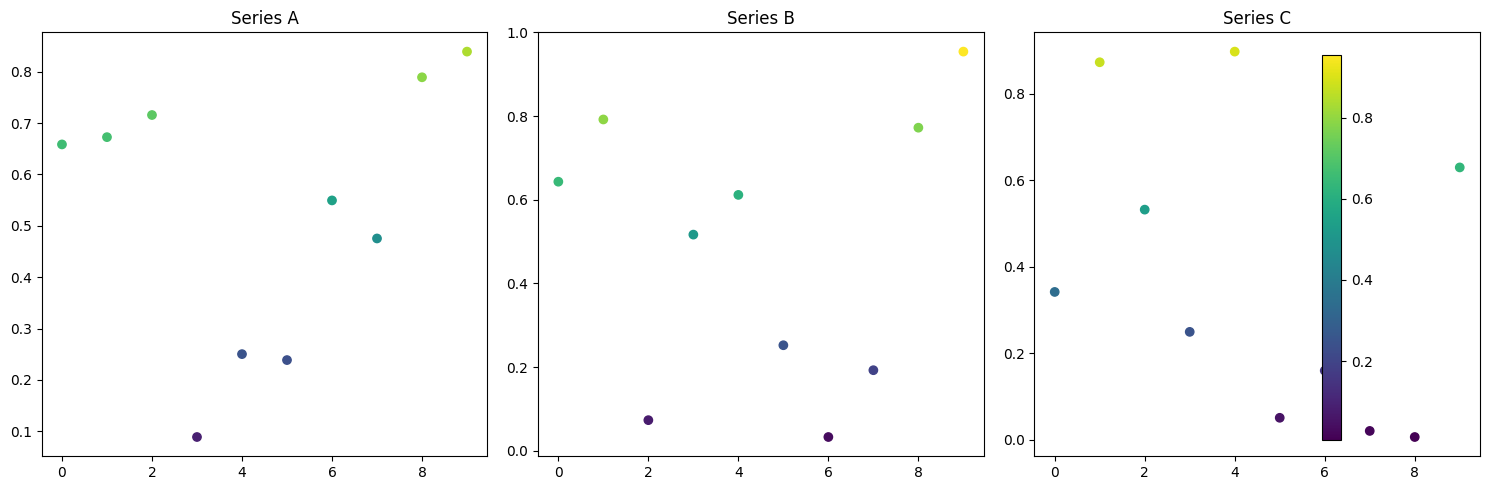

In [55]:
# Sample data
data = pd.DataFrame({
    'A': np.random.rand(10),
    'B': np.random.rand(10),
    'C': np.random.rand(10)
})

# Create a colormap
cmap = plt.get_cmap('viridis')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Normalize the color values
norm = plt.Normalize(vmin=data.values.min(), vmax=data.values.max())

# Plot each subplot with the same colormap
for i, col in enumerate(data.columns):
    sc = axes[i].scatter(data.index, data[col], c=data[col], cmap=cmap, norm=norm)
    axes[i].set_title(f'Series {col}')

# Create a single colorbar for the whole figure
fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()

In [56]:
(outplot[outplot['scenarios']=="W"]) #-outplot.loc[outplot['scenarios']=="H"])

,scenarios,mean_event_length,event_frequency,5day_event_frequency,10day_event_frequency,temp_treshold,flow_percentile,flow_treshold,site,lat,lon,scen_cat
3,W,4.595960,1.736842,0.631579,0.201754,35,0.1,164.770844,422028,-29.942100,146.443100,W
3,W,3.532895,1.333333,0.315789,0.096491,35,0.1,108.694218,422026,-30.104036,147.466436,W
3,W,4.227907,1.885965,0.596491,0.192982,35,0.1,164.227914,422002,-29.947167,146.863717,W
3,W,2.766082,1.500000,0.245614,0.078947,35,0.1,112.568458,422001,-30.015317,148.060750,W
3,W,3.646259,1.289474,0.385965,0.078947,35,0.1,152.764728,422027,-30.143433,147.376867,W
...,...,...,...,...,...,...,...,...,...,...,...,...
3,W,4.516076,10.640351,3.008772,1.298246,35,0.1,0.000000,422502A,-28.922556,146.877750,W
3,W,2.475113,1.938596,0.245614,0.017544,35,0.1,0.295000,410176,-34.863300,148.793100,W
3,W,2.236842,0.666667,0.070175,0.008772,35,0.1,200.000000,425012,-32.436840,142.380230,W
3,W,2.564607,3.122807,0.438596,0.043860,35,0.1,4683.000000,414203,-34.576700,142.767500,W
